In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier

In [25]:
df = pd.read_csv("CreditScoring.csv")

In [26]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [27]:
df.columns.values

array(['Status', 'Seniority', 'Home', 'Time', 'Age', 'Marital', 'Records',
       'Job', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price'],
      dtype=object)

In [28]:
df.columns = df.columns.str.lower()

In [29]:
df.columns.values

array(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype=object)

In [30]:
status_values = {1: 'ok', 2: 'default', 3: "unk"}
# home_values = {1: 'rent', 2: 'owner', 3: 'private', 4: 'ignore', 5: 'parents', 6: 'other', 0: 'unk'}
# marital_values = {1: 'single', 2: 'married', 3: 'widow', 4: 'separated', 5: 'divorced', 6: 'unk'}
# records_values = {1: 'no', 2: 'yes', 3: 'unk'}
# job_values = {1: 'fixed', 2: 'parttime', 3: 'freelance', 4: 'others', 0: 'unk'}

In [31]:
df.status = df.status.map(status_values)
# cs.home = cs.home.map(home_values)
# cs.marital = cs.marital.map(marital_values)
# cs.records = cs.records.map(records_values)
# cs.job = cs.job.map(job_values)

In [32]:
df.head(10)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910
5,ok,1,2,60,36,2,1,1,75,214,3500,0,650,1645
6,ok,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
7,ok,9,5,12,27,1,1,1,35,80,0,0,200,1093
8,ok,0,2,60,32,2,1,3,90,107,15000,0,1200,1957
9,default,0,5,48,41,2,1,2,90,80,0,0,1200,1468


In [33]:
df.describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
home,4455.0,3.0,2.0,0.0,2.0,2.0,4.0,6.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
marital,4455.0,2.0,1.0,0.0,2.0,2.0,2.0,5.0
records,4455.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0
job,4455.0,2.0,1.0,0.0,1.0,1.0,3.0,4.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4455.0,763317.0,8703625.0,0.0,80.0,120.0,166.0,99999999.0
assets,4455.0,1060341.0,10217569.0,0.0,0.0,3500.0,6000.0,99999999.0


In [34]:
for col in ['income', 'assets','debt']:
    df[col] = df[col].replace(to_replace=99999999, value=np.nan)

In [35]:
df.describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
home,4455.0,3.0,2.0,0.0,2.0,2.0,4.0,6.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
marital,4455.0,2.0,1.0,0.0,2.0,2.0,2.0,5.0
records,4455.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0
job,4455.0,2.0,1.0,0.0,1.0,1.0,3.0,4.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4421.0,131.0,86.0,0.0,80.0,120.0,165.0,959.0
assets,4408.0,5403.0,11573.0,0.0,0.0,3000.0,6000.0,300000.0


In [36]:
df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

In [37]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size= 0.25, random_state=42)

In [38]:
len(df_train), len(df_val), len(df_test)

(2673, 891, 891)

In [39]:
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

del(df_train['status'])
del(df_val['status'])

print(df_train.head(10))
print(y_train[0:10])

      seniority  home  time  age  marital  records  job  expenses  income  \
353          14     2    60   30        2        1    1        60    70.0   
990           2     5    60   35        2        1    1        75   104.0   
3289          8     1    36   61        1        1    1        42    72.0   
4002         14     2    60   40        2        1    1        45    91.0   
1273          2     6    60   41        4        1    3        35   100.0   
2019         15     2    60   52        2        2    1        60   130.0   
894          15     1    60   37        2        1    1        58   134.0   
147          14     2    60   64        2        1    3        60   250.0   
2839          2     2    60   32        2        2    1        60   101.0   
397           1     3    48   34        2        2    3        45   200.0   

       assets    debt  amount  price  
353    4000.0  2800.0     600   1125  
990       0.0     0.0    1200   1677  
3289      0.0     0.0     325    45

In [40]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [41]:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_val


[{'seniority': 7,
  'home': 1,
  'time': 36,
  'age': 49,
  'marital': 2,
  'records': 1,
  'job': 1,
  'expenses': 57,
  'income': 115.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 675,
  'price': 675},
 {'seniority': 19,
  'home': 2,
  'time': 48,
  'age': 52,
  'marital': 2,
  'records': 1,
  'job': 1,
  'expenses': 60,
  'income': 68.0,
  'assets': 6000.0,
  'debt': 0.0,
  'amount': 850,
  'price': 1393},
 {'seniority': 2,
  'home': 1,
  'time': 48,
  'age': 36,
  'marital': 5,
  'records': 1,
  'job': 1,
  'expenses': 45,
  'income': 99.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 750,
  'price': 1350},
 {'seniority': 1,
  'home': 2,
  'time': 48,
  'age': 42,
  'marital': 5,
  'records': 1,
  'job': 1,
  'expenses': 35,
  'income': 210.0,
  'assets': 6500.0,
  'debt': 1500.0,
  'amount': 1650,
  'price': 1679},
 {'seniority': 6,
  'home': 1,
  'time': 60,
  'age': 29,
  'marital': 1,
  'records': 1,
  'job': 1,
  'expenses': 45,
  'income': 95.0,
  'assets': 2500.0,
  'debt': 

In [42]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)

In [20]:
def access_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [50]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
X_train.shape
X_val.shape


(891, 13)

In [51]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.7269554926729811

In [52]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6854826718871968

In [55]:
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records <= 1.50
|   |--- income <= 88.50
|   |   |--- class: False
|   |--- income >  88.50
|   |   |--- class: False
|--- records >  1.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



In [56]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.599
   2 -> 0.685
   3 -> 0.730
   4 -> 0.742
   5 -> 0.745
   6 -> 0.743
  10 -> 0.678
  15 -> 0.676
  20 -> 0.656
None -> 0.659


In [57]:
for m in [4, 5, 6]:
    print('depth: %s' % m)
 
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
   
    print()

depth: 4
1 -> 0.742
5 -> 0.749
10 -> 0.749
15 -> 0.749
20 -> 0.749
50 -> 0.757
100 -> 0.753
200 -> 0.752

depth: 5
1 -> 0.741
5 -> 0.749
10 -> 0.751
15 -> 0.754
20 -> 0.754
50 -> 0.758
100 -> 0.748
200 -> 0.752

depth: 6
1 -> 0.743
5 -> 0.732
10 -> 0.736
15 -> 0.736
20 -> 0.734
50 -> 0.749
100 -> 0.749
200 -> 0.752



In [ ]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

In [59]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [60]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7850836978205111

In [61]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=3)

In [62]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7809483687908112

In [63]:
aucs = []
 
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
 
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
 
    aucs.append(auc)

10 -> 0.781
20 -> 0.797
30 -> 0.796
40 -> 0.798
50 -> 0.803
60 -> 0.805
70 -> 0.804
80 -> 0.806
90 -> 0.806
100 -> 0.807
110 -> 0.806
120 -> 0.807
130 -> 0.808
140 -> 0.809
150 -> 0.809
160 -> 0.809
170 -> 0.809
180 -> 0.809
190 -> 0.810
200 -> 0.810


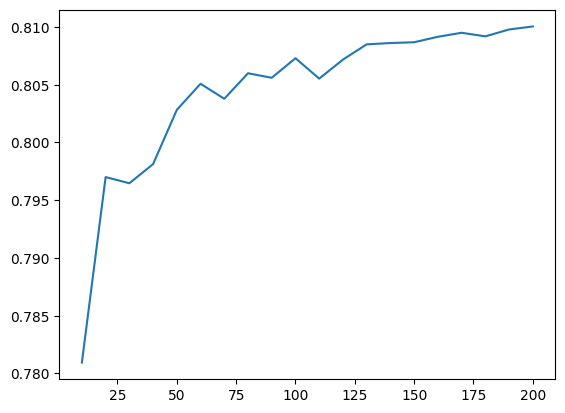

In [64]:
plt.plot(range(10, 201, 10), aucs)

In [65]:
all_aucs = {}
 
for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []
 
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i,
              max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
   
    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.798
20 -> 0.804
30 -> 0.810
40 -> 0.811
50 -> 0.812
60 -> 0.813
70 -> 0.815
80 -> 0.813
90 -> 0.813
100 -> 0.813
110 -> 0.812
120 -> 0.813
130 -> 0.812
140 -> 0.812
150 -> 0.812
160 -> 0.813
170 -> 0.814
180 -> 0.813
190 -> 0.813
200 -> 0.813

depth: 10
10 -> 0.798
20 -> 0.802
30 -> 0.808
40 -> 0.812
50 -> 0.812
60 -> 0.813
70 -> 0.813
80 -> 0.813
90 -> 0.816
100 -> 0.816
110 -> 0.817
120 -> 0.816
130 -> 0.816
140 -> 0.817
150 -> 0.816
160 -> 0.817
170 -> 0.817
180 -> 0.817
190 -> 0.816
200 -> 0.817

depth: 20
10 -> 0.777
20 -> 0.794
30 -> 0.804
40 -> 0.810
50 -> 0.812
60 -> 0.811
70 -> 0.812
80 -> 0.813
90 -> 0.812
100 -> 0.810
110 -> 0.811
120 -> 0.811
130 -> 0.810
140 -> 0.811
150 -> 0.812
160 -> 0.814
170 -> 0.814
180 -> 0.815
190 -> 0.814
200 -> 0.814



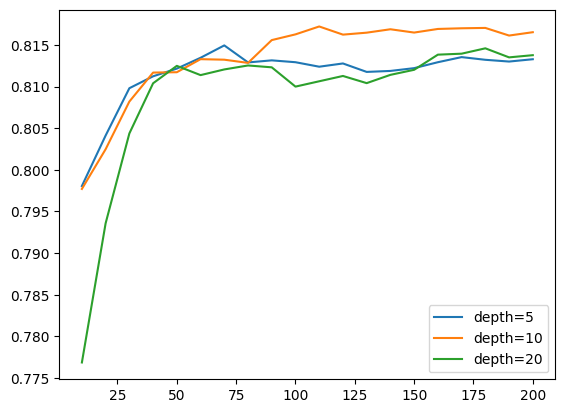

In [66]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.legend()

In [67]:
all_aucs = {}
 
for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
 
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
   
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.792
30 -> 0.811
50 -> 0.815
70 -> 0.818
90 -> 0.817
110 -> 0.819
130 -> 0.818
150 -> 0.818
170 -> 0.818
190 -> 0.818

min_samples_leaf: 5
10 -> 0.786
30 -> 0.807
50 -> 0.815
70 -> 0.816
90 -> 0.815
110 -> 0.816
130 -> 0.817
150 -> 0.817
170 -> 0.818
190 -> 0.819

min_samples_leaf: 10
10 -> 0.786
30 -> 0.810
50 -> 0.809
70 -> 0.810
90 -> 0.813
110 -> 0.814
130 -> 0.814
150 -> 0.814
170 -> 0.816
190 -> 0.817



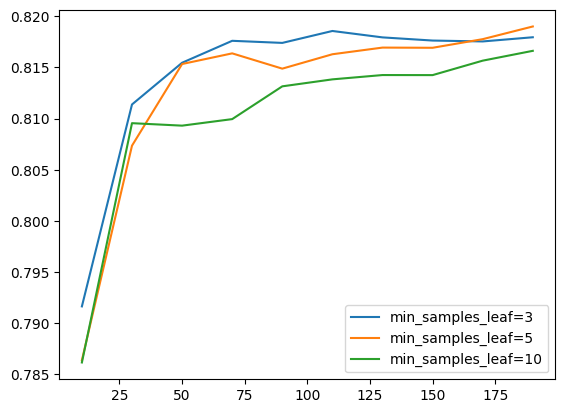

In [68]:
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()

In [73]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8195076015711154

In [74]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)

In [75]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [76]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [77]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

/home/raven/Documents/CS/CS543_ML/mlvenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:15:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [78]:
y_pred = model.predict(dval)

In [79]:
roc_auc_score(y_val, y_pred)

0.7975516374044382

In [80]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [81]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [82]:
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

[0]	train-auc:0.87168	val-auc:0.74602
[10]	train-auc:0.95002	val-auc:0.79836
[20]	train-auc:0.97428	val-auc:0.80462
[30]	train-auc:0.98719	val-auc:0.80096
[40]	train-auc:0.99254	val-auc:0.80041
[50]	train-auc:0.99711	val-auc:0.79699
[60]	train-auc:0.99876	val-auc:0.79427
[70]	train-auc:0.99955	val-auc:0.79365


/home/raven/Documents/CS/CS543_ML/mlvenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:16:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	train-auc:0.99985	val-auc:0.78975
[90]	train-auc:0.99995	val-auc:0.78950
[99]	train-auc:0.99998	val-auc:0.78883


In [83]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [84]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [85]:
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.87168	val-auc:0.74602
[10]	train-auc:0.91935	val-auc:0.78558
[20]	train-auc:0.93888	val-auc:0.80070
[30]	train-auc:0.95257	val-auc:0.80519
[40]	train-auc:0.96178	val-auc:0.81122
[50]	train-auc:0.96874	val-auc:0.81323
[60]	train-auc:0.97340	val-auc:0.81339
[70]	train-auc:0.97838	val-auc:0.81354


/home/raven/Documents/CS/CS543_ML/mlvenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:17:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	train-auc:0.98292	val-auc:0.81253
[90]	train-auc:0.98611	val-auc:0.81081
[100]	train-auc:0.98886	val-auc:0.80764
[110]	train-auc:0.99168	val-auc:0.80769
[120]	train-auc:0.99313	val-auc:0.80715
[130]	train-auc:0.99495	val-auc:0.80608
[140]	train-auc:0.99619	val-auc:0.80541
[150]	train-auc:0.99698	val-auc:0.80417
[160]	train-auc:0.99769	val-auc:0.80315
[170]	train-auc:0.99805	val-auc:0.80281
[180]	train-auc:0.99852	val-auc:0.80097
[190]	train-auc:0.99885	val-auc:0.79991
[200]	train-auc:0.99916	val-auc:0.79903
[210]	train-auc:0.99935	val-auc:0.79769
[220]	train-auc:0.99950	val-auc:0.79618
[230]	train-auc:0.99967	val-auc:0.79590
[240]	train-auc:0.99978	val-auc:0.79624
[250]	train-auc:0.99986	val-auc:0.79594
[260]	train-auc:0.99989	val-auc:0.79668
[270]	train-auc:0.99994	val-auc:0.79562
[280]	train-auc:0.99997	val-auc:0.79542
[290]	train-auc:0.99998	val-auc:0.79557
[300]	train-auc:0.99999	val-auc:0.79448
[310]	train-auc:1.00000	val-auc:0.79359
[320]	train-auc:1.00000	val-auc:0.79276
[3

In [86]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [87]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [89]:
y_train = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values
del df_train_full['status']
del df_test['status']

dict_train = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')
 
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

In [90]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)
 
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}
 
num_trees = 160
 
model = xgb.train(xgb_params, dtrain, num_boost_round=num_trees)

/home/raven/Documents/CS/CS543_ML/mlvenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:18:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [91]:
y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

0.849204675896643